Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
First arg: /home/matheus/Downloads/Tangran3/TangranV2/input/stl_models/01.liver.stl
Second arg: 300.0
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/input/sliced
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/slicing-with-images
number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = 0, model zmax = 199.736, first plane Z = -1.996, number of planes = 102


rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory


-Incremental, 01.liver.stl, thickness = 2, #T = 38142, #P = 100, #S = 37433, 0.018572s (slicing), 0.046529s (polygon assembling), 0.270183s (total), *K: 0.981412


writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing image: ../input/sliced/layer_005.pgm


writing image: ../input/sliced/layer_006.pgm


writing image: ../input/sliced/layer_007.pgm


writing image: ../input/sliced/layer_008.pgm


writing image: ../input/sliced/layer_009.pgm


writing image: ../input/sliced/layer_010.pgm


writing image: ../input/sliced/layer_011.pgm


writing image: ../input/sliced/layer_012.pgm


writing image: ../input/sliced/layer_013.pgm


writing image: ../input/sliced/layer_014.pgm


writing image: ../input/sliced/layer_015.pgm


writing image: ../input/sliced/layer_016.pgm


writing image: ../input/sliced/layer_

Paredes Finas

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
teste: caso de uma unica linha no entorno da origem
teste: caso de uma unica linha no entorno da origem
ai fodeu
[3#mErro: nao fechou contorno
ai fodeu
[3#mErro: nao fechou contorno
Total de [Criando paredes finas] : 20.768867254257202
Total de [Fase 1: Camada: 0] : 20.816694259643555


UnboundLocalError: cannot access local variable 'region' where it is not associated with a value

Contornos

In [6]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 2
Total de [Criando Lvls] : 1.5272064208984375
Criando os loops
Total de [Criando os loops] : 0.5449542999267578
Criando regiões de influência
Total de [Criando regiões de influência] : 0.022603273391723633
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 0.3266463279724121
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:3227 maior void:0.3069608216051731Bw -> aceito
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:28348 maior void:9.548117154811715Bw -> bloqueado
['Lvl_001', 0, 1] Perdendo total:28348 maior void:9.547736782046405Bw -> bloqueado
['Lvl_001', 0, 2] Perdendo total:4921 maior void:0.5968048687713959Bw -> bloqueado
['Lvl_001', 0, 3] Perdendo total:51395 maior void:9.475846329402815Bw -> bloqueado
Total de [Retirando regiões da camada] : 0.12757468223571777
Reunindo todos os loops em uma unica imagem
Total de [Reunindo todos os loops em 

Pontes

In [7]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        c.prohibited_areas = last_prohibited_areas
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas))
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
# %reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 1.136272668838501
Criando pontes de Zigzag
Total de [Criando pontes de Zigzag] : 2.6086957454681396
Criando pontes de Crossover
Total de [Criando pontes de Crossover] : 0.009917259216308594
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.010754108428955078
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.0002319812774658203
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.05769014358520508
Total de [Fase 3: Camada: 0] : 3.8437774181365967
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 1.4308733940124512
Criando pontes de Zigzag
Total de [Criando pontes de Zigzag] : 2.605346202850342
Criando pontes de Crossover
Total de [Criando pontes de Crossover] : 0.010062932968139648
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.01609945297241211
Gerando áreas proibidas
Total de [Gerando áreas proibidas] 

Zigzags

In [8]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.2752056121826172
salvando imagens das regiões
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.024454355239868164
Total de [Fase 4: Camada: 0] : 1.3308439254760742
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.3039753437042236
salvando imagens das regiões
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.02435779571533203
Total de [Fase 4: Camada: 1] : 1.3596305847167969
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.8177666664123535
salvando imagens das regiões
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.02

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.17590618133544922
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.14859461784362793
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.14194130897521973
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.14874625205993652
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.14220547676086426
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.1448671817779541
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.14568281173706055
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.24285674095153809
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.1429603099822998
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.14706707000732422


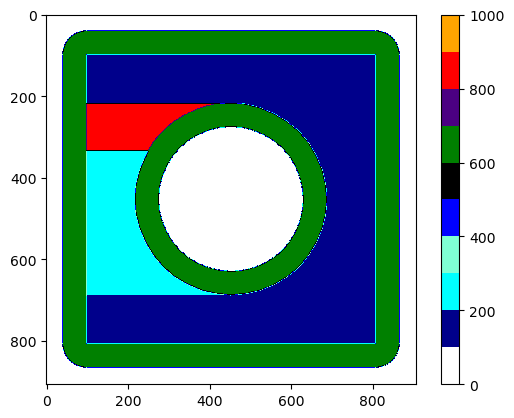

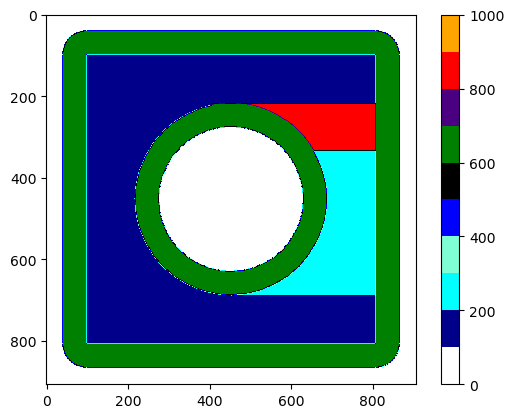

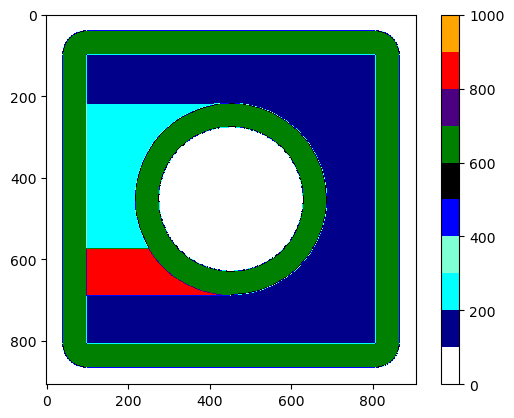

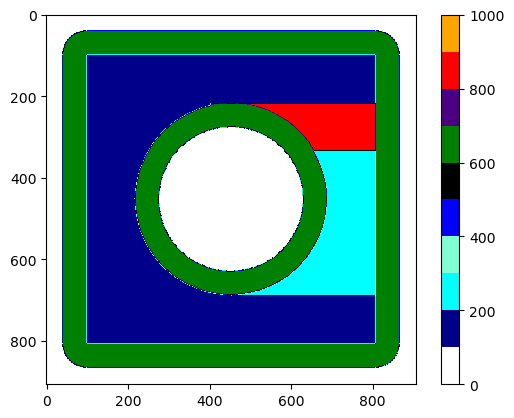

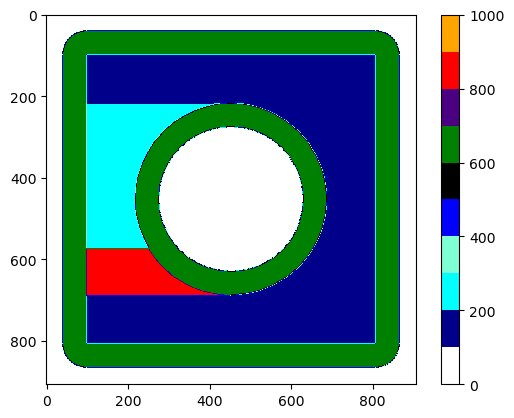

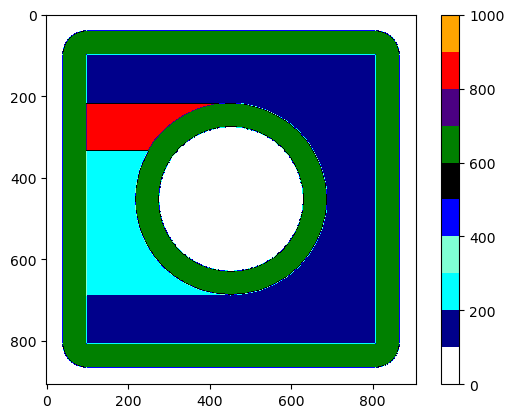

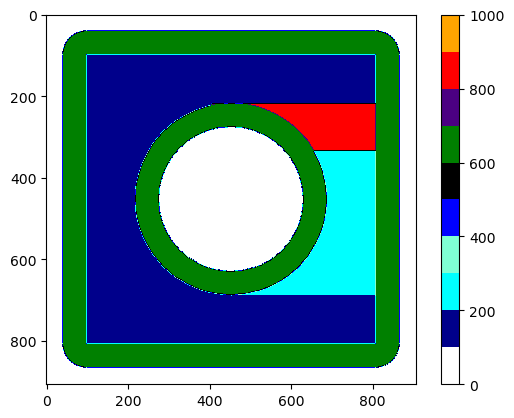

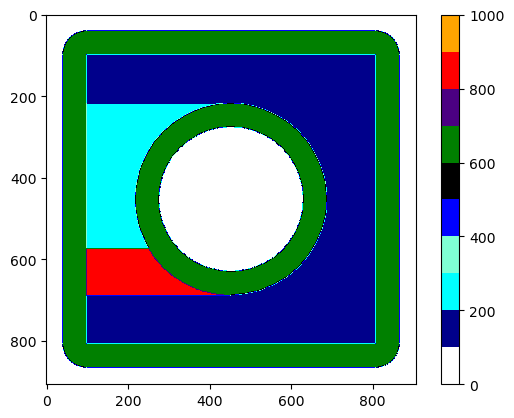

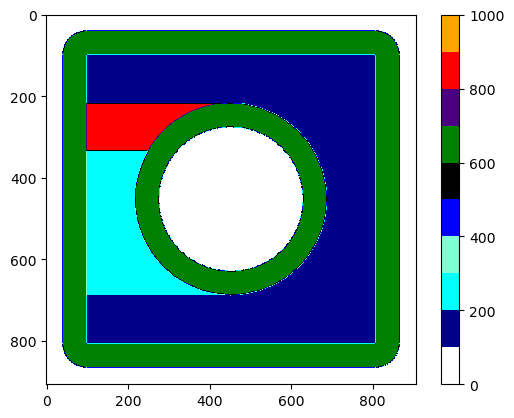

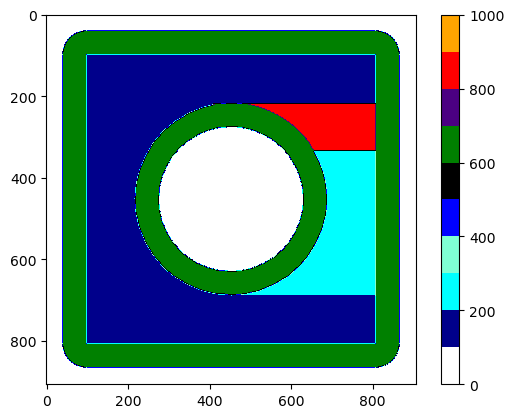

In [9]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [10]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.04729795455932617
Total de [Making offset routes] : 1.75278639793396
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.045387983322143555
Total de [Making offset routes] : 1.9069349765777588
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0461428165435791
Total de [Making offset routes] : 1.8413453102111816
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.04588818550109863
Total de [Making offset routes] : 1.6944787502288818
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.05095362663269043
Total de [Making offset routes] : 1.8861405849456787
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.06225323677062988
Total de [Making offset routes] : 1.868091344833374
Making offset routes
salvando imagens

Rotas de pontes

In [11]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.059923410415649414
Total de [Making bridges routes] : 0.26833653450012207
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.04569697380065918
Total de [Making bridges routes] : 0.26372671127319336
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.054553985595703125
Total de [Making bridges routes] : 0.3092191219329834
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.04310441017150879
Total de [Making bridges routes] : 0.28586721420288086
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.044599294662475586
Total de [Making bridges routes] : 0.3162498474121094
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.04890847206115723
Total de [Making bridges routes] : 0.28029298782348633
Making bridges 

Rotas de Ziguezague

In [12]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 4.257508754730225
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.2924675941467285
fazendo as tres opções:
Total de [fazendo as tres opções:] : 9.233306646347046
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.2924036979675293
Total de [criando as rotas de zigzag, camada:L_000] : 15.3184974193573
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0649869441986084
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.008330821990966797
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.0014340877532958984
salvando grafos
Total de [salvando grafos] : 0.0947108268737793
Total de [Making zigzag routes] : 15.632410526275635
Making zigzag routes
criando as rotas de zigzag, camada:L_001
fazendo as tres opções:
Total de [fazendo as tres opções:] : 4.746429204940796
escolhendo entre elas:
T

In [13]:
#WEAVING

import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 1.0014541149139404
salvando rotas
Total de [salvando rotas] : 0.11877703666687012
Total de [Fase 5 b] : 1.1211395263671875
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.9922523498535156
salvando rotas
Total de [salvando rotas] : 0.1193549633026123
Total de [Fase 5 b] : 1.1123981475830078
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 1.0931050777435303
salvando rotas
Total de [salvando rotas] : 0.14844250679016113
Total de [Fase 5 b] : 1.2428059577941895
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.9905867576599121
salvando rotas
Total de [salvando rotas] : 0.11820840835571289
Total de [Fase 5 b] : 1.1095294952392578
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 1.009751796722412
salvando rotas
Total 

Rotas de Thin Walls

In [14]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 3.1948089599609375e-05
Total de [Making thin walls routes] : 0.021562814712524414
Total de [Fase 5] : 0.02170276641845703
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.5987625122070312e-05
Total de [Making thin walls routes] : 0.02171635627746582
Total de [Fase 5] : 0.02173590660095215
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.8133392333984375e-05
Total de [Making thin walls routes] : 0.019741296768188477
Total de [Fase 5] : 0.019762754440307617
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.6702880859375e-05
Total de [Making thin walls routes] : 0.019494056701660156
Total de [Fase 5] : 0.019513607025146484
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.6464462280273438e

Unificando rotas EXTERNAS nas camadas

In [15]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
47
48
49
50
51
52
53
54
Total de [Encontrando ponto de união ext-int] : 0.18651390075683594
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 1.1003539562225342
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 6.532669067382812e-05
Total de [Conectando rotas externas] : 1.43263840675354
salvando imagens das rotas
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.1822805404663086
Total de [Fase 6] : 1.6227765083312988
Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
47
48
49
50
51
52
53
54
Total de [Encontrando ponto de união ext-int] : 0.0915062427520752
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 1.0621309280395508
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 4.935264587402344e-05
Total de [Conectando rotas externas] : 1.3118700981140137
salvando imagens das

Unificando rotas INTERNAS nas camadas

In [16]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 2.4110631942749023
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0018818378448486328
salvando imagens das rotas
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.07452750205993652
Total de [Fase 7] : 2.6366677284240723
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 2.470716714859009
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0017604827880859375
salvando imagens das rotas
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.07134175300598145
Total de [Fase 7] : 2.692171096801758
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 2.5202815532684326
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0017459392547607422
salvando imagens das rotas
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.07163357734680176
Total de [Fase 7] : 2.73426914215

Unindo rotas de thin walls

In [17]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0005140304565429688
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0566554069519043
Total de [Fase 8] : 0.08110809326171875
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.00052642822265625
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.056887149810791016
Total de [Fase 8] : 0.07892346382141113
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0005888938903808594
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.08351683616638184
Total de [Fase 8] : 0.11218881607055664
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0005097389221191406
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.05936145782470703
Total de [Fase 8] : 0.09034395217895508
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0008716583251953125
salvando imagens das rot

Unindo todas as rotas e criando codigo G

In [1]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, p_religamento, p_desligamento, vel_vazio, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

internal_trees = []
external_trees = []
tw_trees = []
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        
for c in camadas:
    c.close_final_path(folders)
    for isl in c.islands:
        internal_trees.append([list(x) for x in isl.internal_tree_route.sequence])
        external_trees.append([list(x) for x in isl.external_tree_route.sequence])
        tw_trees.append([list(x) for x in isl.thinwalls_tree_route.sequence])

layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               internal_trees,
                               external_trees,
                               tw_trees,
                               p_religamento,
                               p_desligamento,
                               vel_vazio,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.009026765823364258
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.008866310119628906
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.007348060607910156
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.006898164749145508
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.008449792861938477
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.010434150695800781
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.007416725158691406
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.008758783340454102
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.0076334476470947266
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.014443159103393555
layer rotacionada
Cuspindo o Gcode
trocou para 

In [19]:
import numpy as np
camadas = folders.load_layers_hdf5()
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
        print(internal_trees)
print([235,807] in internal_trees)

[[783, 783], [782, 783], [781, 783], [780, 783], [779, 783], [778, 783], [777, 783], [776, 783], [775, 783], [774, 783], [773, 783], [772, 783], [771, 783], [770, 783], [769, 783], [768, 783], [767, 783], [766, 783], [765, 783], [764, 783], [763, 783], [762, 783], [761, 783], [760, 783], [759, 783], [758, 783], [757, 783], [756, 783], [755, 783], [754, 783], [753, 783], [752, 783], [751, 783], [750, 783], [749, 783], [748, 783], [747, 783], [746, 783], [745, 783], [744, 783], [743, 783], [742, 783], [741, 783], [740, 783], [739, 783], [738, 782], [737, 781], [736, 780], [735, 779], [734, 778], [733, 777], [732, 776], [731, 775], [730, 774], [729, 775], [728, 776], [727, 777], [726, 778], [725, 779], [724, 780], [723, 781], [722, 782], [721, 783], [720, 784], [719, 784], [718, 784], [717, 784], [716, 784], [715, 784], [714, 784], [713, 784], [712, 784], [711, 784], [710, 784], [709, 784], [708, 784], [707, 784], [706, 784], [705, 784], [704, 784], [703, 784], [702, 784], [701, 784], [70

In [20]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [21]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)